# Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
from IPython.display import Image, display

from tree_interp_functions import *

In [2]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Load Data

In [3]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone_df = pd.read_csv('abalone.csv', names=column_names)
abalone_df['sex'] = abalone_df['sex'].map({'F': 0, 'I': 1, 'M': 2})
abalone_df['y'] = abalone_df.rings.map(lambda x: 1 if x > 9 else 0)
abalone_df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,y
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


In [4]:
# Set up training and sets sets.
abalone_train, abalone_test = train_test_split(abalone_df, test_size=0.2)

X_train = abalone_train.iloc[:, :-2]
y_train = abalone_train.y

X_test = abalone_test.iloc[:, :-2]
y_test = abalone_test.y

X_train = X_train.copy().reset_index(drop=True)
y_train = y_train.copy().reset_index(drop=True)
X_test = X_test.copy().reset_index(drop=True)
y_test = y_test.copy().reset_index(drop=True)

# Build Model

In [5]:
# dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,
#                                 random_state=0)
dt_clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=100,
                                random_state=0)
dt_clf.fit(X_train, y_train)

y_prob = dt_clf.predict_proba(X_test)[:, 1]
dt_clf.score(X_test, y_test)
auc = roc_auc_score(y_test, y_prob)
print auc

0.89397689769


## Create feature contribution
We use the `ti.predict` function to get our contributions. This is a 3d array which represents the contribution for each example, feature, and class label.

In [6]:
pred, bias, contrib = ti.predict(dt_clf, X_test)

# Create DataFrame containing contributions
contrib_df = pd.DataFrame(contrib[:, :, 1], columns=X_test.columns)

# Plot Feature Importances

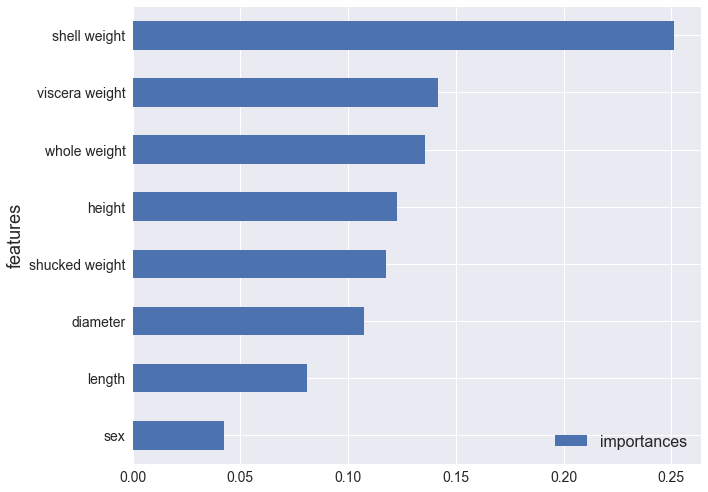

In [7]:
df_importances = pd.DataFrame({'features': X_train.columns,
                               'importances': dt_clf.feature_importances_
                              })
df_importances\
    .set_index('features')\
    .sort_values('importances')\
    .plot(kind='barh')
plt.tight_layout()

# Plot Feature Contributions

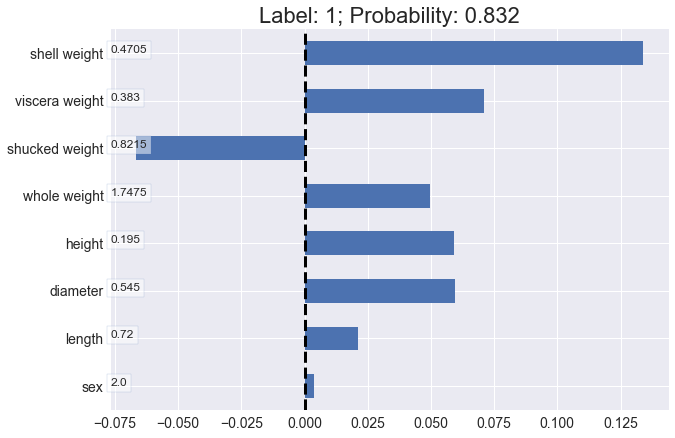

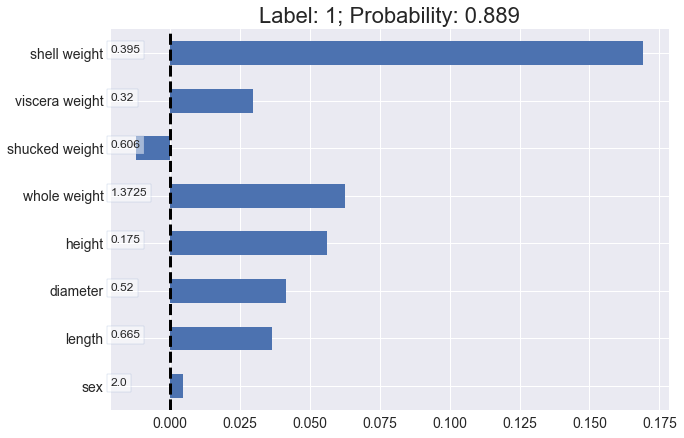

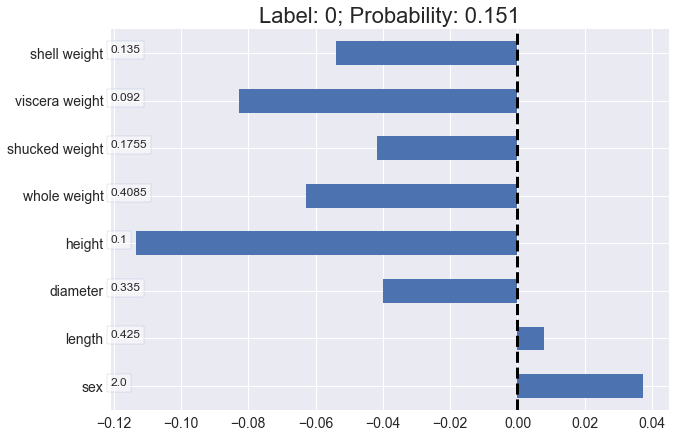

In [8]:
for i in xrange(3):
    _ = plot_top_feat_contrib(dt_clf, contrib_df, X_test, y_test, i, 5)

In [9]:
# WIP
ax=contrib_df.drop(['label','pred_prob'],axis=1).plot(kind='box',vert=False)
plt.axvline(0,linestyle='--', color='black', lw=1)
ax.set_xlabel('Feature Contribution')
# row.drop(['label','pred_prob']).plot(kind='barh',ax=ax)
for y_coord,(f,v) in enumerate(row.drop(['label','pred_prob']).iteritems()):
    plt.scatter(v,y_coord+1,s=100,c='green')

for y_coord,(f,v) in enumerate(X_test.iloc[n].iteritems()):
    plt.text(-0.4,y_coord+1,'{:2.2f}'.format(v))
#     plt.v(v,y_coord,'{:2.2f}'.format(v))

ValueError: labels ['label' 'pred_prob'] not contained in axis

# Plotting Individual Features

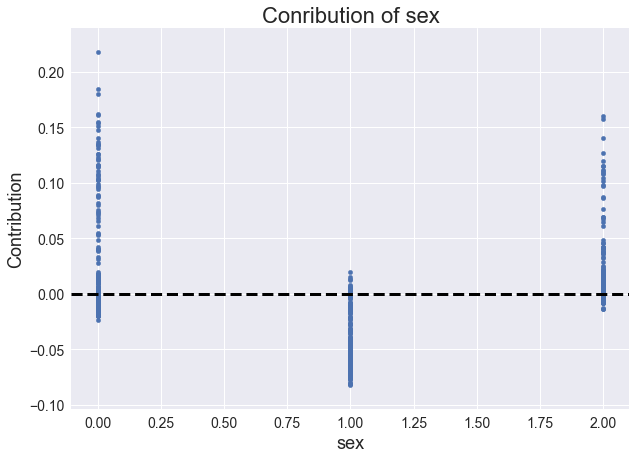

In [10]:
plot_single_feat_contrib('sex', X_test, contrib_df)

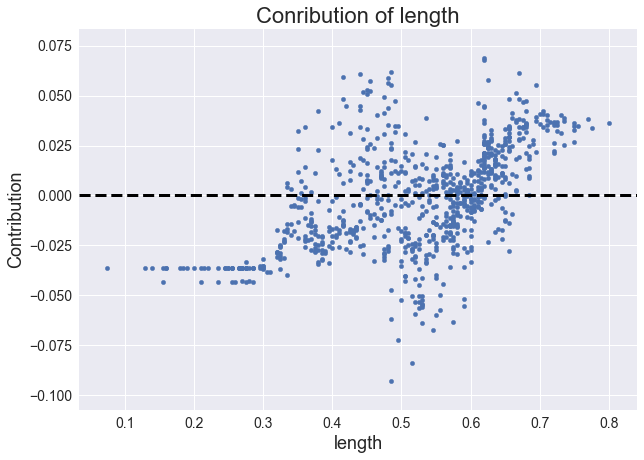

In [11]:
plot_single_feat_contrib('length', X_test, contrib_df)

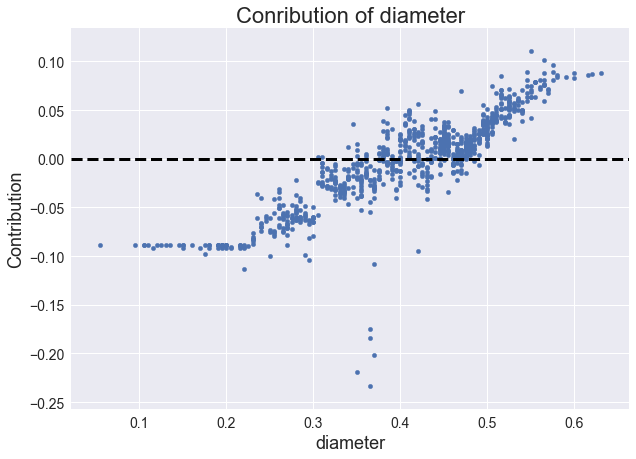

In [12]:
plot_single_feat_contrib('diameter', X_test, contrib_df)

# Visualize Tree

In [ ]:
dot_data = export_graphviz(dt_clf.estimators_[0],
                           out_file=None,
                           feature_names=X_train.columns
                          )
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
print contrib_df.query('label == 1').mean()
print contrib_df.query('label == 0').mean()

In [ ]:
n = 5
example = X_train.iloc[n:n+1, :]
display(example)